# The moving average model: MA(q)

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (9,6)

## Simulate a MA(1) process 

In [4]:
ma1 = np.array([1, 0.9])
ar1 = np.array([1, 0])

ma1_process = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

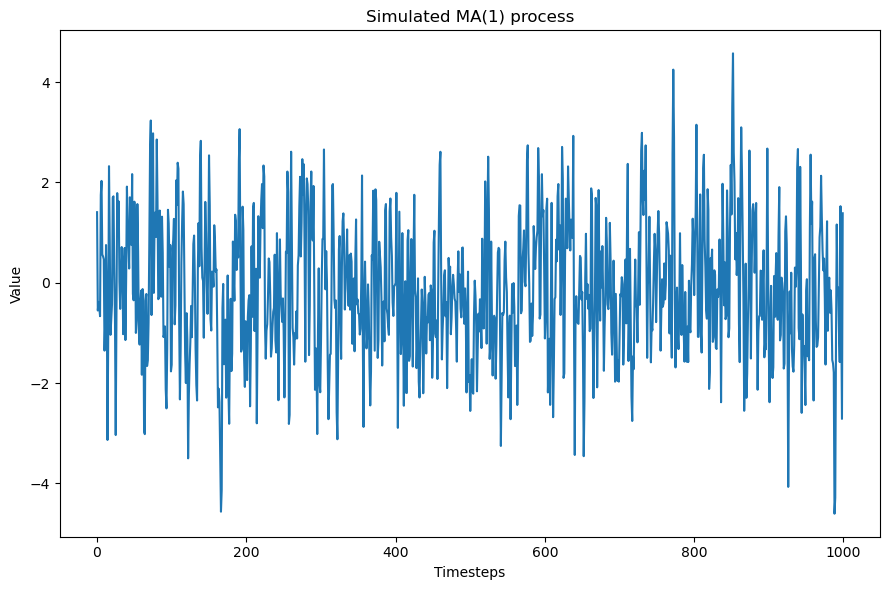

In [5]:
fig, ax = plt.subplots()

ax.plot(ma1_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.title('Simulated MA(1) process')

plt.tight_layout()

In [6]:
ADF_result = adfuller(ma1_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -8.456599404436956
p-value: 1.6086022616136924e-13


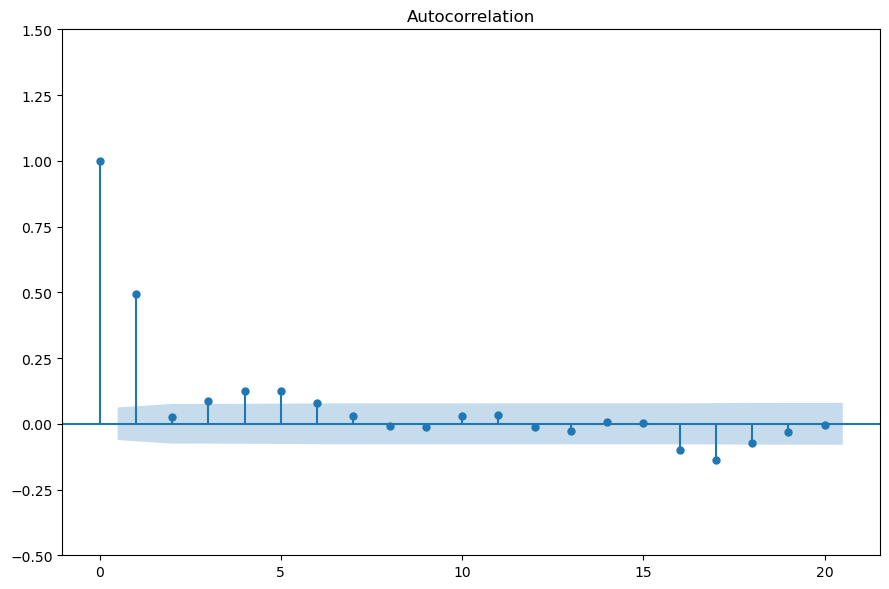

In [7]:
plot_acf(ma1_process, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

## Forecasting with the MA(q) model 

In [8]:
df = pd.read_csv('data/simulated_MA3.csv')
df.head()

,value
0,50.000000
1,50.679213
2,51.771045
3,50.959927
4,52.162826


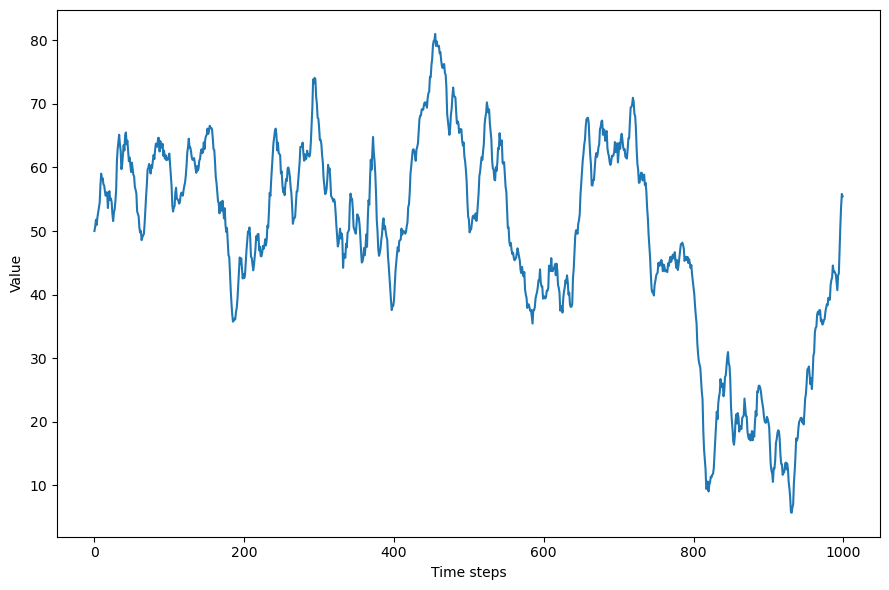

In [9]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.set_xlabel('Time steps')
ax.set_ylabel('Value')

plt.tight_layout()

### Test for stationarity 

In [10]:
ADF_result = adfuller(df['value'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.434661174390715
p-value: 0.13219152456766498


In [11]:
series_diff = np.diff(df['value'], n=1)

In [12]:
ADF_result = adfuller(series_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.149220026451233
p-value: 7.634171271238697e-08


### Plot ACF 

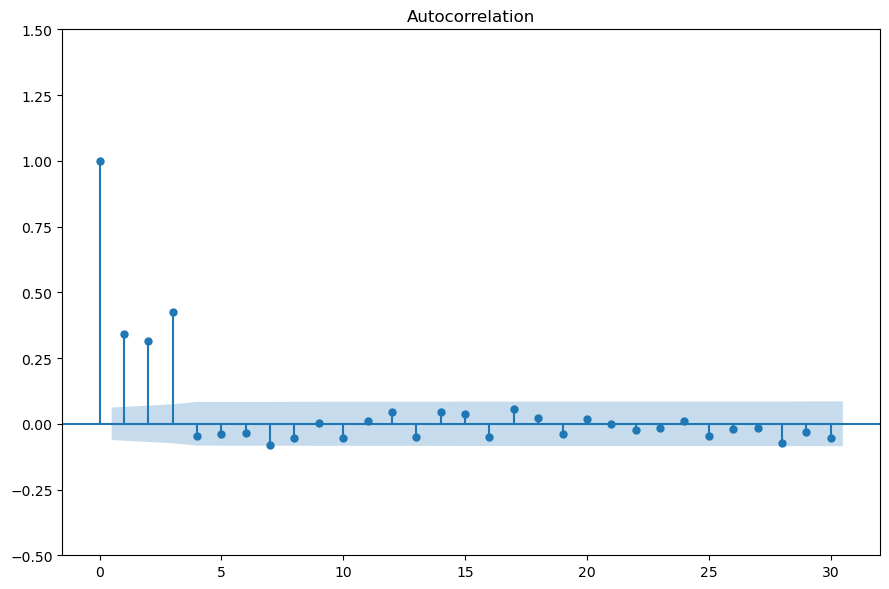

In [13]:
plot_acf(series_diff, lags=30);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

In [14]:
df_diff = pd.DataFrame({'value_diff': series_diff})

train = df_diff[:-100]
test = df_diff[-100:]

print(len(train))
print(len(test))

899
100


In [15]:
df_diff

,value_diff
0,0.679213
1,1.091831
2,-0.811117
3,1.202898
4,0.767791
...,...
994,3.759281
995,3.649196
996,3.048385
997,2.026817


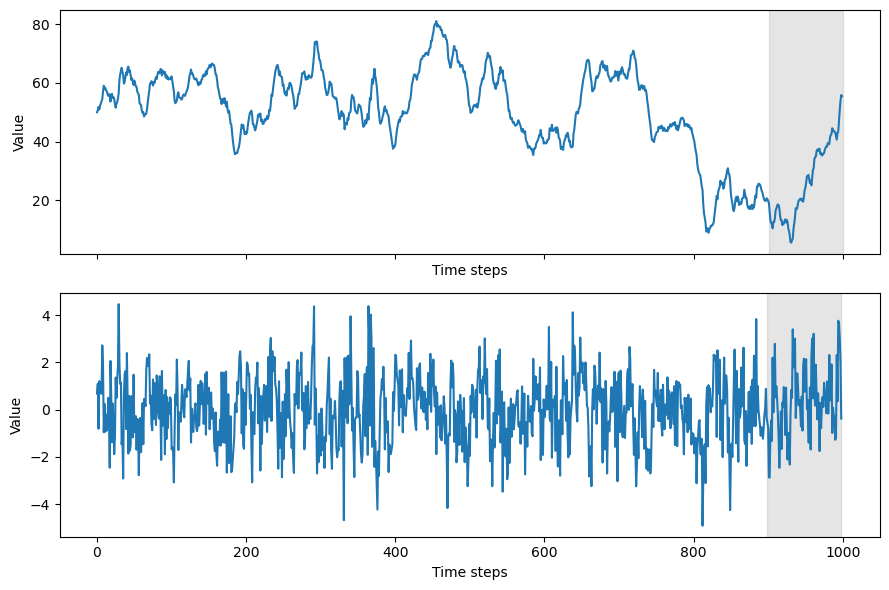

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['value'])
ax1.set_xlabel('Time steps')
ax1.set_ylabel('Value')
ax1.axvspan(901, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff['value_diff'])
ax2.set_xlabel('Time steps')
ax2.set_ylabel('Value')
ax2.axvspan(899, 998, color='#808080', alpha=0.2)

plt.tight_layout()

In [17]:
def rolling_predictions(df_diff: pd.DataFrame, last_train_value: np.array, train_len: int, horizon: int, window: int, method: str) -> list:
    
    TOTAL_LEN = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, TOTAL_LEN, window):
            mean = np.mean(df_diff[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        pred_mean = np.concatenate((last_train_value, pred_mean))
        pred_mean = pred_mean.cumsum()

        return pred_mean[:100]

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_value = df_diff[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        pred_last_value = np.concatenate((last_train_value, pred_last_value))
        pred_last_value = pred_last_value.cumsum()
        
        return pred_last_value[:100]
    
    if method == 'MA':
        pred_MA = []
        
        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(df_diff[:i], order=(0,0,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        pred_MA = np.concatenate((last_train_value, pred_MA))
        pred_MA = pred_MA.cumsum()
            
        return pred_MA[:100]

In [18]:
pred_df = df[-100:].copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
LAST_TRAIN_VALUE = df.iloc[899].values

windows = [1, 2, 5, 10]

for window in windows:
    pred_mean = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'mean')
    pred_last = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'last')
    pred_MA = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'MA')

    pred_df[f'pred_mean_{window}'] = pred_mean
    pred_df[f'pred_last_{window}'] = pred_last
    pred_df[f'pred_MA_{window}'] = pred_MA

pred_df.head()

,value,pred_mean_1,pred_last_1,pred_MA_1,pred_mean_2,pred_last_2,pred_MA_2,pred_mean_5,pred_last_5,pred_MA_5,pred_mean_10,pred_last_10,pred_MA_10
900,19.875135,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815
901,19.097637,20.391917,20.078006,21.504891,20.391917,20.078006,21.504891,20.391917,20.078006,21.504891,20.391917,20.078006,21.504891
902,16.226323,20.358445,19.528326,21.219128,20.359019,19.731197,21.617298,20.359019,19.731197,21.617298,20.359019,19.731197,21.617298
903,13.347418,20.324147,18.750828,19.472226,20.324721,18.953699,19.870396,20.326121,19.384388,20.663190,20.326121,19.384388,20.663190
904,12.320159,20.286704,15.879515,17.596162,20.290423,18.176202,18.268598,20.293223,19.037579,20.663190,20.293223,19.037579,20.663190


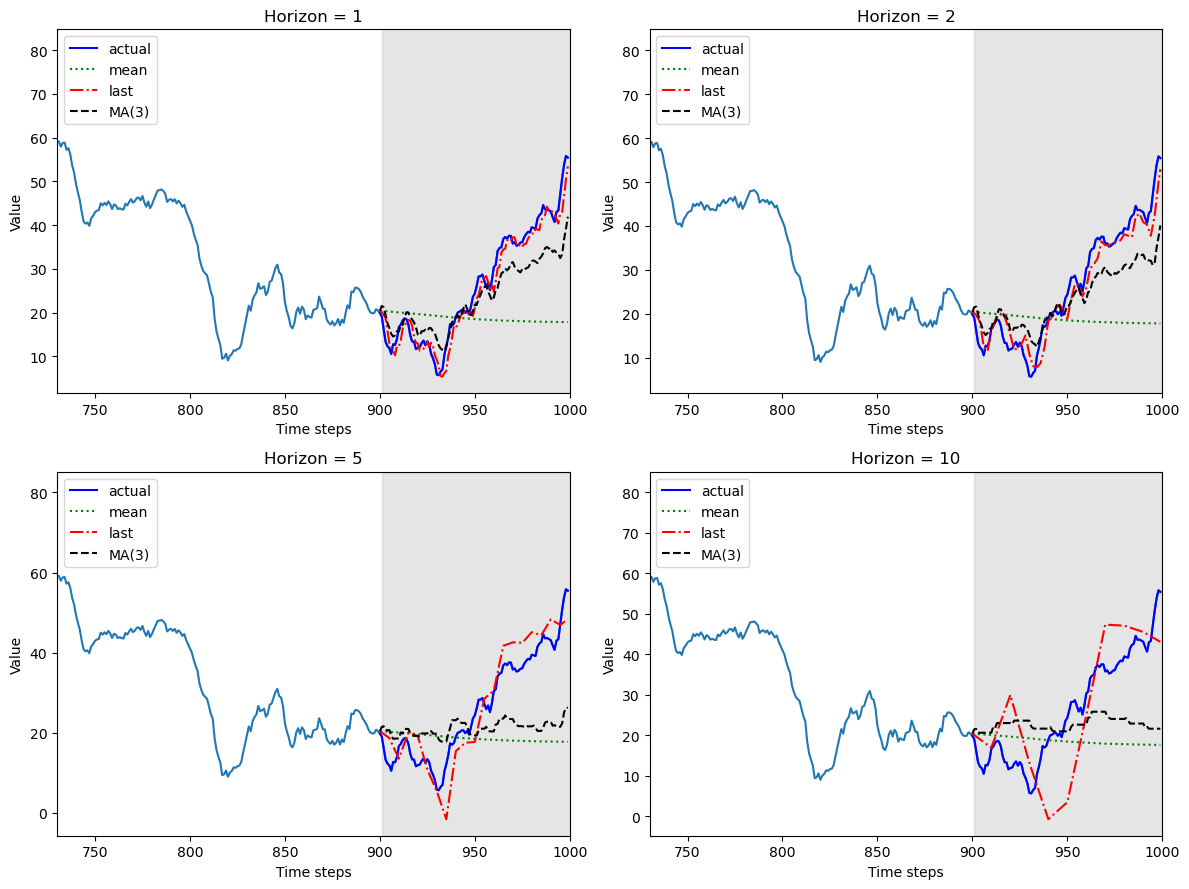

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(df['value'])
    ax.plot(pred_df['value'], 'b-', label='actual')
    ax.plot(pred_df[f'pred_mean_{windows[i]}'], 'g:', label='mean')
    ax.plot(pred_df[f'pred_last_{windows[i]}'], 'r-.', label='last')
    ax.plot(pred_df[f'pred_MA_{windows[i]}'], 'k--', label='MA(3)')
    
    ax.legend(loc=2)
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.axvspan(901, 1000, color='#808080', alpha=0.2)
    ax.set_xlim(730, 1000)
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.tight_layout()

In [20]:
from sklearn.metrics import mean_absolute_error

mae_mean_1 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_1'])
mae_last_1 = mean_absolute_error(pred_df['value'], pred_df['pred_last_1'])
mae_MA_1 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_1'])

mae_mean_2 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_2'])
mae_last_2 = mean_absolute_error(pred_df['value'], pred_df['pred_last_2'])
mae_MA_2 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_2'])

mae_mean_5 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_5'])
mae_last_5 = mean_absolute_error(pred_df['value'], pred_df['pred_last_5'])
mae_MA_5 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_5'])

mae_mean_10 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_10'])
mae_last_10 = mean_absolute_error(pred_df['value'], pred_df['pred_last_10'])
mae_MA_10 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_10'])

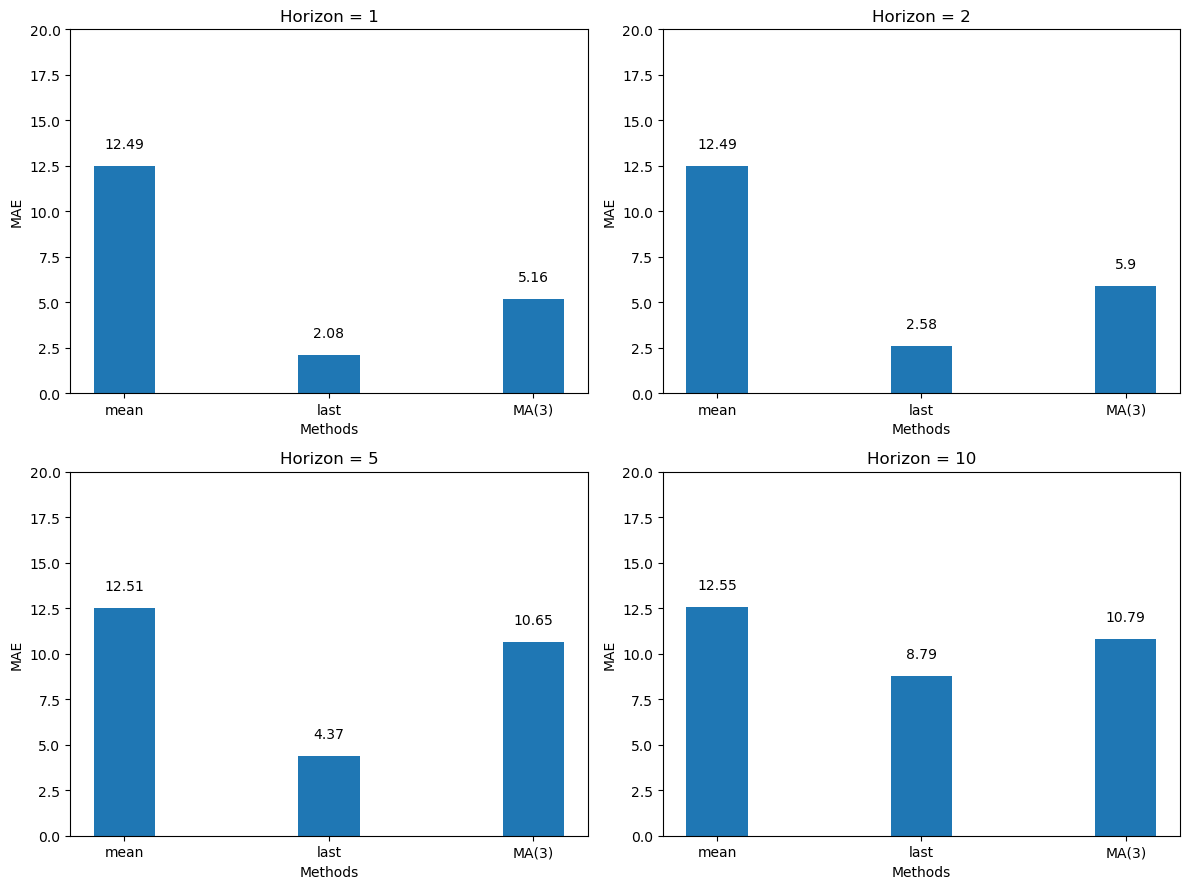

In [21]:
maes_mean = [mae_mean_1, mae_mean_2, mae_mean_5, mae_mean_10]
maes_last = [mae_last_1, mae_last_2, mae_last_5, mae_last_10]
maes_MA = [mae_MA_1, mae_MA_2, mae_MA_5, mae_MA_10]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

x = ['mean', 'last', 'MA(3)']
width = 0.3

for i, ax in enumerate(axes.flatten()):
    
    y = [maes_mean[i], maes_last[i], maes_MA[i]]
    ax.bar(x, y, width)
    ax.set_xlabel('Methods')
    ax.set_ylabel('MAE')
    ax.set_ylim(0, 20)
    ax.set_title(f'Horizon = {windows[i]}')    
    
    for index, value in enumerate(y):
        ax.text(x=index, y=value+1, s=str(round(value, 2)), ha='center')

plt.tight_layout()